# Behavior Cloning

## Objective: Fly balloon as far as possible.

1.Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning).

- The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning.

## For Colab users

In [1]:
# Clone the repository
import os
import sys

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
    sys.path.append('/content/balloon-outreach/')
    %cd balloon-outreach/
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

✅ Found: /content/balloon-outreach
/content/balloon-outreach


In [2]:
# Install required packages
!pip install -r requirements.txt

In [3]:
## Colab users ##

import sys
sys.path.append('/content/balloon-outreach/')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField

In [4]:
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'

elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found: /content/drive/My Drive/era5_data.nc


## Import Packages

In [8]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
from utils.learning_util import plot_expert_summary, plot_agent_summary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment

In [9]:
ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)


#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0

target_lat = None
target_lon = None
target_alt = None

time_step = 120 #120 seconds
objective = 'fly'

env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)


WindField initialized with noise enabled. noise scale: 1.0


In [10]:
env.wind_field.disable_noise()
initial_state = env.reset()
print(initial_state) # 21-dimensional vector

# state = (latitude, longitude, altitude, volume/max_volume, sand/max_sand,
# vertical velocity, current_time, uv vectors in 7 different pressure levels)

[ 42.6        -76.5         10.           1.           1.
   0.           0.           2.68826294  -2.50693054  11.1584198
  -7.97099304  14.01635132  -5.00876465  27.14085999   3.41699524
  34.82033386  14.09255371  38.58664856   7.6340332   18.78843994
  -4.25058899]


## Define expert policy

In [11]:
# Parameters for MPPI agent

max_steps = int(1440/(time_step/60)) #1 day

num_samples=10
acc_bounds= (-0.1, 0.1)
noise_std = 0.1
num_iterations=1
temperature=10
horizon = 10

In [12]:
expert = MPPIAgentWithCostFunction(target_lat=target_lat,
                                   target_lon=target_lon,
                                   target_alt=target_alt,
                                   num_samples=num_samples,
                                   acc_bounds= acc_bounds,
                                   noise_std=noise_std,
                                   num_iterations=num_iterations,
                                   temperature=temperature,
                                   horizon=horizon,
                                   visualize=False,
                                   objective=objective)

## Collect expert state-action pair

In [13]:
# Run an episode from an expert and collect its behavior

def run_expert_episode(
        env: BalloonERAEnvironment,
        agent:MPPIAgent,
        max_steps: int = 100,
        dt: int = 60,
        policy_name: str='expert'):
    """
    Run one episode with the given agent,
    collect state-action pair of the agent,
    and plot its trajectory in the given environment.
    """
    # Save state-action pairs from expert policy
    initial_states = []
    initial_actions = []

    state = env.reset()
    total_reward = 0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []
    for step in range(max_steps):
        # Get action from agent
        action = agent.select_action(state, env, step)

        # record state and expert action
        initial_states.append(state)
        initial_actions.append(action)

        # Take step
        state, reward, done, info = env.step(action)
        total_reward += reward

        actions.append(float(action[0]) if isinstance(action, np.ndarray) else float(action))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])
        # print(f"Step {step}: lat: {state[0]:.2f}, lon: {state[1]:.2f}, alt: {state[2]:.2f}")

        if done:
            print(f"\nEpisode terminated: {info}")
            break

    # Convert to arrays
    states_np = np.array(initial_states, dtype=np.float32)
    actions_np = np.array(initial_actions, dtype=np.float32)
    print(f"Collected {len(initial_states)} state-action pairs from expert.")

    # --- Combined 2x2 Summary Plot ---
    plot_fnm = plot_expert_summary(agent, trajectory, altitudes, actions, velocities, helium_mass, sands, policy_name, max_steps, dt)

    return total_reward, states_np, actions_np, plot_fnm

In [14]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
expert_total_reward_list = []
expert_states_list = []
expert_actions_list = []
expert_plot_fnms_list = []
num_iter = 3
for i in range(num_iter):
    expert_total_reward, expert_states_np, expert_actions_np, fnm = run_expert_episode(env, expert, max_steps=max_steps, dt=time_step, policy_name=f'expert_{i+1}')
    expert_total_reward_list.append(expert_total_reward)
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)
    expert_plot_fnms_list.append(fnm)


Episode terminated: Time limit reached
Collected 720 state-action pairs from expert.
Initial position: [np.float64(42.6), np.float64(-76.5)], End position: [np.float64(77.2), np.float64(-82.7)], Distance: 3858.033518398676 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10

Episode terminated: Time limit reached
Collected 720 state-action pairs from expert.
Initial position: [np.float64(42.6), np.float64(-76.5)], End position: [np.float64(77.3), np.float64(-82.7)], Distance: 3869.0443067332517 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10

Episode terminated: Time limit reached
Collected 720 state-action pairs from expert.
Initial position: [np.float64(42.6), np.float64(-76.5)], End position: [np.float64(77.2), np.float64(-82.7)], Distance: 3858.033518398676 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10


In [15]:
expert_plot_fnms_list

['figs/fly/balloon_summary_expert_1_((77.2,-82.7)_(10s,1it,10h,10t)_err_3858.03km.png',
 'figs/fly/balloon_summary_expert_2_((77.3,-82.7)_(10s,1it,10h,10t)_err_3869.04km.png',
 'figs/fly/balloon_summary_expert_3_((77.2,-82.7)_(10s,1it,10h,10t)_err_3858.03km.png']

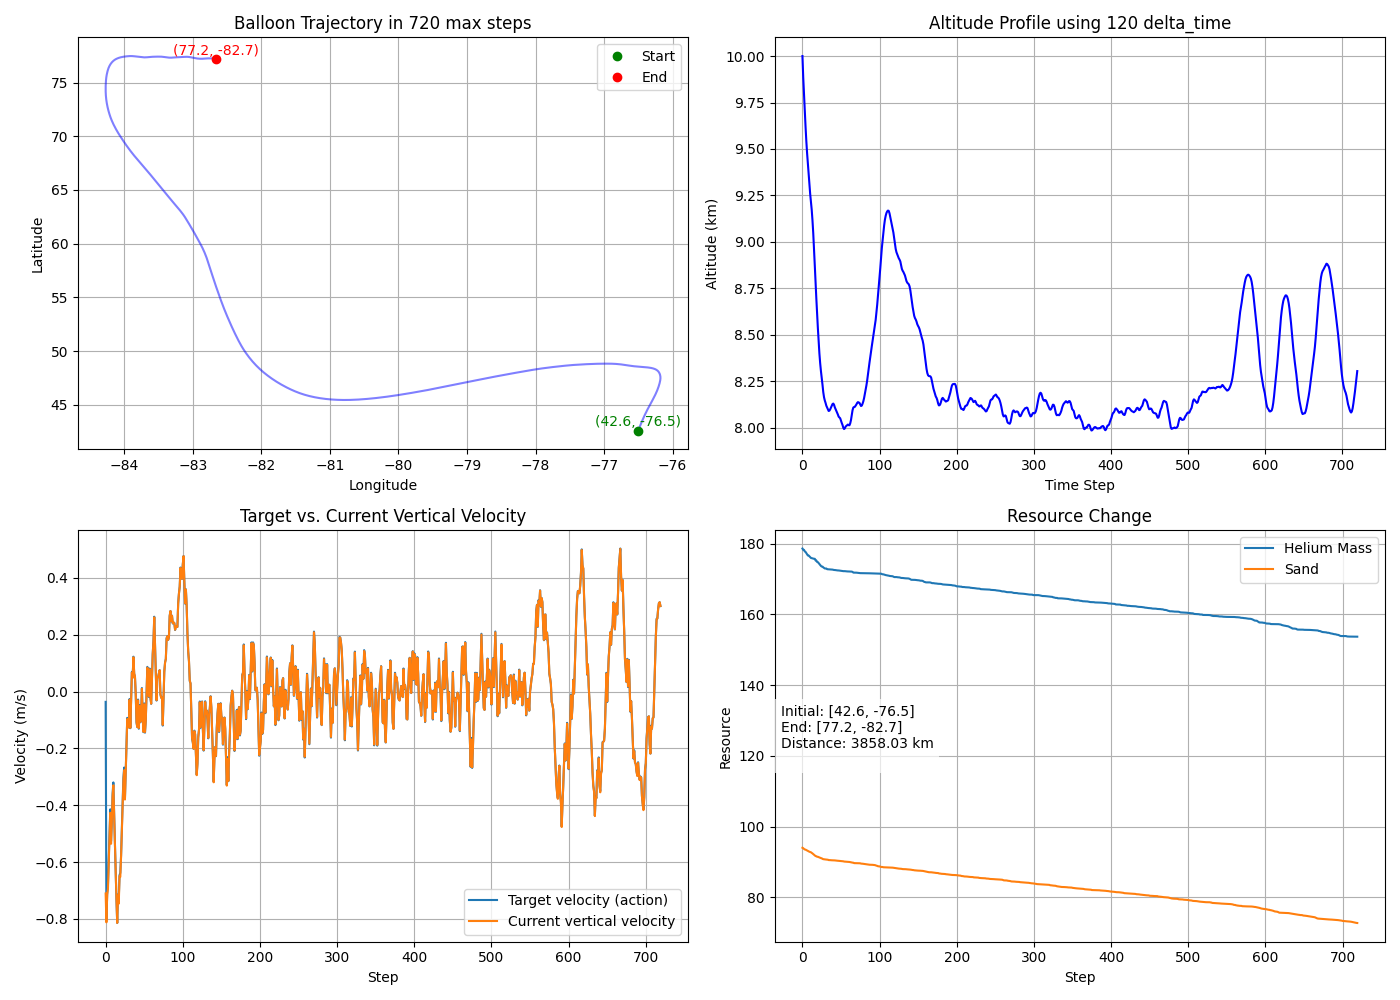

In [16]:
from IPython.display import Image, display
display(Image(filename=expert_plot_fnms_list[0]))

In [17]:
print(expert_total_reward_list)
expert_avg_total_reward = sum(expert_total_reward_list)/len(expert_total_reward_list)
print(f"Expert Trajectory reward in average: {expert_avg_total_reward:.2f}")

[np.float64(1444601.0498356791), np.float64(1408252.5441374653), np.float64(1425790.8007195136)]
Expert Trajectory reward in average: 1426214.80


In [18]:
expert_states_np = np.concatenate(expert_states_list)
expert_actions_np = np.concatenate(expert_actions_list)

## Define our policy network

In [34]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

print(any(p.isnan().any().item() for p in policy.parameters()))

False


In [35]:
# Evaluate a policy on the environment
def evaluate_policy(env: BalloonERAEnvironment,
                    policy: nn.Module,
                    objective: str,
                    max_steps: int,
                    policy_name: str,
                    expert_avg_total_reward: float):
    policy.eval()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    state = env.reset()
    total_reward = 0.0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []

    for step in range(max_steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)      # shape (1, 21)
        assert not torch.isnan(state_tensor).any(), "NaNs in state!"

        action_pred = policy(state_tensor)                               # continuous action
        assert not torch.isnan(action_pred).any(), "NaNs in action prediction!"

        state, reward, done, info = env.step(action_pred.item())
        total_reward += reward

        actions.append(float(action_pred) if isinstance(action_pred, np.ndarray) else float(action_pred))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])

        if done:
            print(f"\nEpisode terminated: {info}")
            break
    print(f"Total reward obtained from current policy: {total_reward:.2f}")
    print(f"Expert policy reward - Current policy reward: {expert_avg_total_reward-total_reward:.2f}")

    # Plot summary (figs/BC_fly)
    plot_fnm = plot_agent_summary(
        trajectory=trajectory,
        altitudes=altitudes,
        actions=actions,
        velocities=velocities,
        helium_mass=helium_mass,
        sands=sands,
        policy_name=policy_name,
        max_steps=max_steps,
        dt=env.dt,
        objective=objective,
        target_lon=env.target_lon,
        target_lat=env.target_lat,
        target_alt=env.target_alt
        )

    return total_reward, plot_fnm

In [36]:
env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            add_noise=False,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
total_reward, random_fnm = evaluate_policy(env, policy, objective, max_steps=max_steps, policy_name='random_policy', expert_avg_total_reward=expert_avg_total_reward)

WindField initialized with noise disabled.
→ policy is in evaluation mode

Episode terminated: No sand left
Total reward obtained from current policy: 975788.44
Expert policy reward - Current policy reward: 450426.36
Initial position: [np.float64(42.6), np.float64(-76.5)], End position: [np.float64(69.3), np.float64(-82.4)], Distance: 2988.3883432091625 km


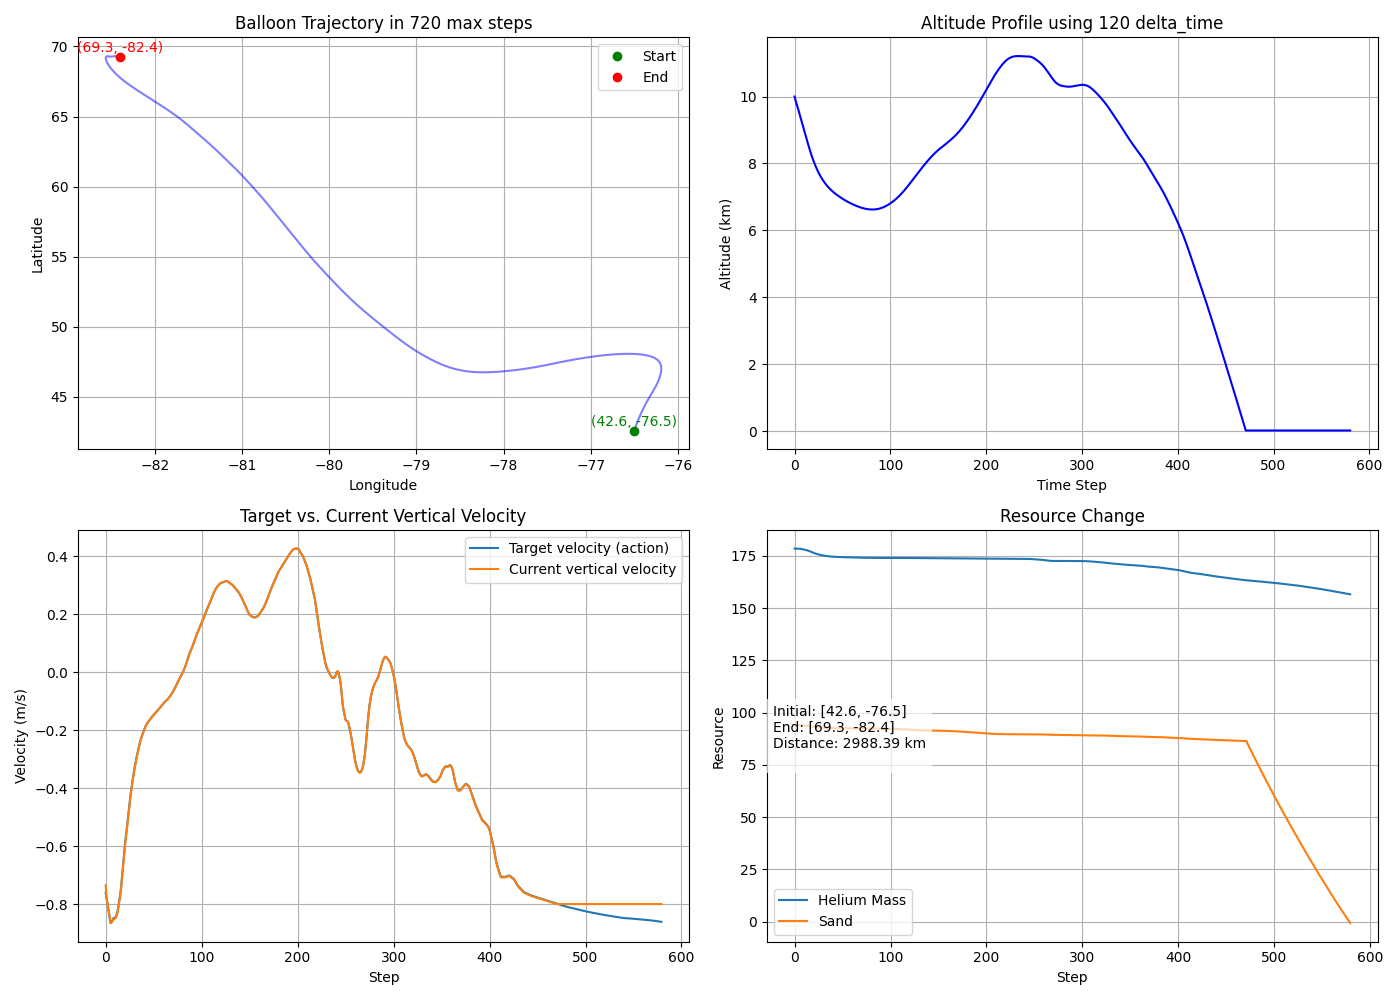

In [37]:
display(Image(filename=random_fnm))

## Behavior Cloning (Supervised Learning)

In [38]:
# === Initial Dataset & DataLoader Construction ===

# Convert to tensors
states_tensor = torch.from_numpy(expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [39]:
# === Training Function Using Loader ===
def train_one_epoch(loader, policy, optimizer, loss_fn):
    policy.train()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    total_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = policy(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

→ policy is in training mode
Epoch 1/5 — Avg Loss: 0.320562 

→ policy is in training mode
Epoch 2/5 — Avg Loss: 0.071781 

→ policy is in training mode
Epoch 3/5 — Avg Loss: 0.043150 

→ policy is in training mode
Epoch 4/5 — Avg Loss: 0.035517 

→ policy is in training mode
Epoch 5/5 — Avg Loss: 0.032265 



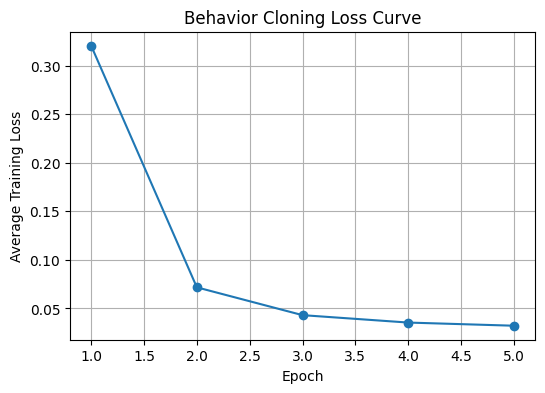

In [40]:
losses = []
for epoch in range(5):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/5 — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from behavior cloning
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

In [41]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
toal_reward, BC_trained_fnm = evaluate_policy(env, policy, objective, max_steps=max_steps, policy_name='BC_trained_far_policy', expert_avg_total_reward=expert_avg_total_reward)

→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: 1328273.92
Expert policy reward - Current policy reward: 97940.88
Initial position: [np.float64(42.6), np.float64(-76.5)], End position: [np.float64(76.5), np.float64(-83.3)], Distance: 3783.293642306856 km


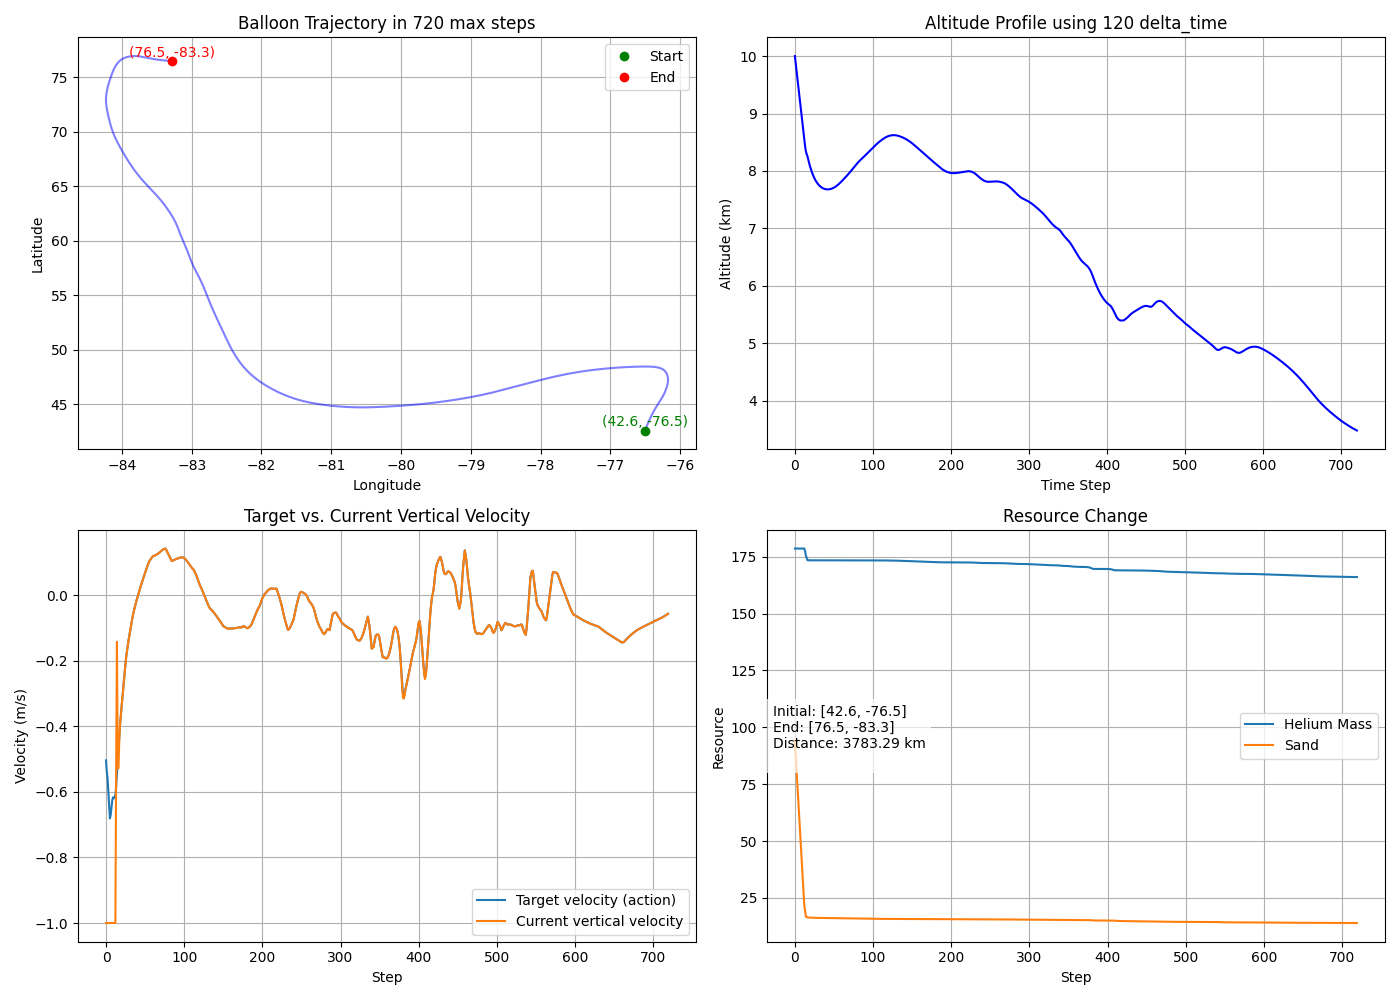

In [42]:
display(Image(filename=BC_trained_fnm))

## Save training data and trained network to your own Google Drive
- The saved model will be used in Imitation Learning.

In [43]:
folder_nm = expert_plot_fnms_list[0].split('/')[0] + '/' + expert_plot_fnms_list[0].split('/')[1]
print(folder_nm)

figs/fly


In [48]:
## Save summary plots of expert and trained neural network.
import shutil

if not os.path.isdir('/content/drive/My Drive/Nb9/'+folder_nm):
    os.makedirs('/content/drive/My Drive/Nb9/'+folder_nm)

for path in expert_plot_fnms_list:
    shutil.copyfile('/content/balloon-outreach/'+path, '/content/drive/My Drive/Nb9/'+path)

shutil.copyfile('/content/balloon-outreach/'+BC_trained_fnm, '/content/drive/My Drive/Nb9/'+BC_trained_fnm)

'/content/drive/My Drive/Nb9/figs/fly/balloon_summary_BC_trained_far_policy_((76.5,-83.3)_err_3783.29km.png'

In [49]:
## Expert trajectory and the summary

expert_data = {
    'expert_states_np' : expert_states_np,
    'expert_actions_np': expert_actions_np,
    'expert_plot_fnms_list' : expert_plot_fnms_list,
    'expert_total_reward_list' : expert_total_reward_list
}

In [50]:
## Save trained neural network

checkpoint = {
    'expert_data' : expert_data,
    'BC_trained_plot_fnm' : BC_trained_fnm,
    'model_state_dict' : policy.state_dict()
}

torch.save(checkpoint, '/content/drive/My Drive/Nb9/'+folder_nm+'/policy_checkpoint.pth')